# Minimum working example of dynamic rupture modeling on gouge patch event.

In this notebook we generate an input file for the dynamic rupture modeling of gouge patch event.

2025.3.21 Kurama Okubo


In [53]:
import os
import sys
import shutil
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
from datetime import datetime

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set case study variables

In [54]:
a_patch = 4.0e-3 # patch radius without margine
rupturetype = "pulse" # "crack": without self-healing or "pulse": with self-healing
p_dcscaleexp = 0.6 # Dc scaling exponent to the slip

In [55]:
casestudy_name = f"a={a_patch*1e3:.2f}_ruptype={rupturetype:s}_pdcscaling={p_dcscaleexp:.3f}"
print(casestudy_name)

a=4.00_ruptype=pulse_pdcscaling=0.600


# Theory to derive the model parameters

The key parameters are the stress drop and $Dc$, which are unknown due to the causal loop: the "true" stress drop and $D_c$ can be estimated from fitting the data to the dynamic rupture simulation, whereas we need first set them to run the simulation. Ideally, the iterative approch can solve this loop. However, it is way too much in our purpose as we already have apriori information on the source paramters. To solve this loop, we set the trial parameters inferred from the gouge patch size and the seismic moment. Note that we set the gouge patch size as the free parameter to answer the question if this affects the conclusions.

We set the stress drop as followings:

$$ \bar{ \Delta \sigma } _{\text{try}}^{(i)} = \dfrac{7}{16} \dfrac{M_0^{(i)}}{a^3_{\text{patch}}}, $$

where $(i)$ indicates the parameter of the $i$th event. We use $a_{\text{patch}} = 4.0$ mm + $0.08$ mm of the patch margin for the initial condition.

$$ \bar{u}_{\text{try}}^{(i)} = \dfrac{M_0^{(i)}}{\mu \pi a^2_{\text{patch}}} $$

where $\bar{u}_{\text{try}}^{(i)}$ is the trial averaged slip.

We set the initial shear stress as the fraction of peak friction:

$$ \tau_0 = cf_p\sigma_n, $$

where $c$ determines the coefficient of initial traction fraction. Then, we set the $f_p$ as follows:

$$ \Delta\sigma = cf_p\sigma_n - f_r\sigma_n $$
$$ f_p = \dfrac{1}{c}\left[ \dfrac{s\Delta\sigma}{\sigma_n} + f_r \right] $$ 

Here, $\Delta\sigma$ is controlled with the `dynamic_excess`, $s$, as $ \Delta\sigma = s \bar{ \Delta \sigma } _{\text{try}}^{(i)} $ to control the amplitude of STF.

To estimate the $D_c$ as follows:

$$ D_{c}^{(i)} =  \dfrac{D_c^{\text{min}}}{\min \left\{ \bar{u}_{\text{try}} \right\}^{p} } \bar{u}_{\text{try}}^{(i)p},$$

$D_c^{\text{min}}$ indicates the best-fit $D_c$ for the case of minimum gouge event, which we find by trial and error. $p$ is the scaling exponent with the trial slip.

When the trial parameters are validated with the observations, i.e., source time functions with non-self-similarity, we can evaluate the "true" paramters such as $\bar{ \Delta \sigma } _{\text{true}}^{(i)}$ and $\bar{u}_{\text{true}}^{(i)}$ as well as the true source region $A_{\text{true}}$.

**NOTE:**

The way to define $D_c$ has been updated from our previous work. We used the energy budget such as Dc = (1-$\eta_R$)$\bar{u}$, but it has an assumption of the radiated energy inferred from the kinematic source model. As the direct observation of $E_R$ is unstable and difficult, we changed the derivation as described above. In this metric, we consider the increase in the  $\bar{u}_{\text{try}}^{(i)p}$ from the $D_c$ to model the minimum event, which we predefine with a emperical constant value. 

# Set model parameters

In [56]:
# Elastic constant
E = 96e9
rho = 2980
nu = 0.246 # metagabbro
mu = E/(2*(1+nu))

print(f"E, mu, rho = {E:.4g} {mu:.4g} {rho:.4g}")

R_patch = a_patch #4e-3 # gouge patch radius 
R_margin = a_patch+0.08e-3 #4.08e-3 #4.1e-3 #5e-3 # This is the outer bound of the stress margin, used for the input parameter of simulation
# R_margin = a_patch

# Set the range of average GIIC
A_patch = np.pi * R_patch**2

hat_sn_patch = 6e6 #8e6 # normal stress on gouge patch
hat_sn_background = 2e6 # normal stress on background region

hat_fr_patch = 0.3 # fixed the residual friction level as an assumption
hat_tau_r_patch = hat_sn_patch * hat_fr_patch

E, mu, rho = 9.6e+10 3.852e+10 2980


## Recompute case study parameters

In [57]:
gougepatch_id = "G3" # to set output filename
denoise_method = "detrend"
Qinv_quart = 50
k_waterlevel = 0.3
expr_id = 87

foname_mean = f"../../ComputeScaling/data/05_STFstats/SourceParam_meanstd_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_stats = pd.read_csv(foname_mean, index_col=2)

In [58]:
df_stats.head()

,index,datacase,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std
gougeevent_id,,,,,,,,
4,fb03-087,fb03-087__0004,50,4,0.592607,0.178671,0.000003,1.530315e-07
9,fb03-087,fb03-087__0009,50,4,0.046991,0.007419,0.000002,3.643121e-07
18,fb03-087,fb03-087__0018,50,4,0.755830,0.192507,0.000003,3.100882e-07
19,fb03-087,fb03-087__0019,50,4,0.055755,0.016951,0.000002,2.699155e-07
20,fb03-087,fb03-087__0020,50,4,0.865466,0.210250,0.000003,1.352659e-07


In [59]:
Qinv_quart = "50"
NvalidSensor = 4

df_stats_selected = df_stats[(df_stats["Qinv_quart"] == Qinv_quart) & (df_stats["Nvalidsensors"] >= NvalidSensor)].copy()
df_stats_selected.head()
print(f"Num. event = {len(df_stats_selected)}")

Num. event = 33


In [60]:
df_stats_selected["Tw_mean"] * 1e6

gougeevent_id
4      2.558865
9      2.346274
18     2.865571
19     2.484483
20     2.766240
21     2.309987
24     2.464508
27     2.546613
31     2.584020
38     2.254324
40     2.161388
43     2.364047
44     2.448315
50     2.578979
52     2.601549
61     2.614260
62     2.541439
69     2.112112
72     2.606032
77     2.632667
85     2.292748
88     2.413383
89     2.477632
95     2.773236
99     2.952894
100    2.915759
109    2.797569
118    2.001607
120    2.759853
126    1.991559
128    2.231325
129    2.626343
131    2.496772
Name: Tw_mean, dtype: float64

In [61]:
def M02Mw(M0):
    """
    convert from M0 to Mw
    """
    return (np.log10(M0) - 9.105) * 2.0 / 3.0


In [62]:
df_stats_selected.loc[:, "Mw_mean"] = df_stats_selected.apply(lambda x: M02Mw(x.M0_mean), axis=1)


In [63]:
M0_stats = (df_stats_selected['M0_mean'].mean(), df_stats_selected['M0_mean'].std(), df_stats_selected['M0_mean'].min(), df_stats_selected['M0_mean'].max())
Mw_stats = (df_stats_selected['Mw_mean'].mean(), df_stats_selected['Mw_mean'].std(), df_stats_selected['Mw_mean'].min(), df_stats_selected['Mw_mean'].max())

In [64]:
print("M0 stats: {0[0]:.3f} ± {0[1]:.3f} Nm with the range from {0[2]:.3f} to {0[3]:.3f} Nm.".format(M0_stats))
print("Mw stats: {0[0]:.3f} ± {0[1]:.3f} with the range from {0[2]:.3f} to {0[3]:.3f}.".format(Mw_stats))

M0 stats: 0.513 ± 0.360 Nm with the range from 0.013 to 1.255 Nm.
Mw stats: -6.414 ± 0.382 with the range from -7.329 to -6.004.


In [65]:
# make a dataframe for the dynamic rupture parameters
df_dynparam = df_stats_selected[["M0_mean", "Tw_mean", "Mw_mean"]].copy()
df_dynparam.head()

,M0_mean,Tw_mean,Mw_mean
gougeevent_id,,,
4,0.592607,0.000003,-6.221489
9,0.046991,0.000002,-6.955323
18,0.755830,0.000003,-6.151051
19,0.055755,0.000002,-6.905809
20,0.865466,0.000003,-6.111833


In [66]:
df_dynparam.loc[:, "hat_sn_patch"] = hat_sn_patch
df_dynparam.loc[:, "hat_sn_background"] = hat_sn_background


In [67]:
#1. compute trial stress drop
df_dynparam["delsig_withmargin_try"] = df_dynparam.apply(lambda x: (7/16) * (x.M0_mean/R_margin**3), axis=1)

#2. compute trial average slip
df_dynparam["slip_try"] = df_dynparam.apply(lambda x: x.M0_mean/(mu * np.pi * R_margin**2), axis=1)

In [68]:
df_dynparam.sort_values("Mw_mean")

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try
gougeevent_id,,,,,,,
128,0.012927,0.000002,-7.329002,6000000.0,2000000.0,8.327120e+04,6.416584e-09
126,0.017021,0.000002,-7.249339,6000000.0,2000000.0,1.096451e+05,8.448860e-09
21,0.021466,0.000002,-7.182167,6000000.0,2000000.0,1.382760e+05,1.065506e-08
9,0.046991,0.000002,-6.955323,6000000.0,2000000.0,3.027004e+05,2.332502e-08
19,0.055755,0.000002,-6.905809,6000000.0,2000000.0,3.591569e+05,2.767536e-08
24,0.065639,0.000002,-6.858558,6000000.0,2000000.0,4.228248e+05,3.258138e-08
44,0.069443,0.000002,-6.842249,6000000.0,2000000.0,4.473256e+05,3.446933e-08
118,0.076079,0.000002,-6.815824,6000000.0,2000000.0,4.900745e+05,3.776340e-08
43,0.186189,0.000002,-6.556697,6000000.0,2000000.0,1.199367e+06,9.241898e-08


## Set the frictional parameters

|  |  $\sigma_n$  | $\tau_0$ | $f_p$ | $f_r$ |
| ---- | ---- | ---- | ---- | ---- | 
| nucleation zone | $\alpha \hat{\sigma}_n$ | Gaussian distribution | $f_p$ | $\hat{f}_r$ |
| gouge patch zone | $\hat{\sigma}_n$ | 0.925*$\tau_p$ | $f_p$ | $\hat{f}_r$ |
| stress margin | 0 | 0 | 0 | 0 |
| background region | $\hat{\sigma}_n^{background}$ | $\beta \tau_r$ | $f_p = \hat{f}_r$| $\hat{f}_r$ |



In [69]:
# # Master unirateral + best case

R_nuc = 2.5e-3 #1.5e-3 # nucleation radius 
A_nuc = np.pi * R_nuc**2

nuc_x = -(R_patch - R_nuc) #-(0.5*R_patch) # x coordinate of the center of the nucleation area

# Parameter of the background zone 
print(f"hat_fr_patch={hat_fr_patch}")
hat_fp_background = 0.4 #0.3 # estimated from macroscopic friction value
hat_fr_background = 0.4 #0.3

nuc_normalstress_alpha = 1.0 # amplication factor of the normal stress on the nucleation zone

stressbackground_beta = 0.35 #0.3 #0.4 #0.3 # factor to define the background stress level; this decides the strength of barrier

#--- set the self-healing parameter---#
if rupturetype=="crack":
    hat_ds_factor_rapidnuc_nuc = 10000 # factor of slip-strengthening distance in the nucleation zone
    hat_ds_factor_rapidnuc_patch =  10000 # factor of slip-strengthening distance in the patch area
    
elif rupturetype=="pulse":
    hat_ds_factor_rapidnuc_nuc = 5.5 #6.5 #5.5  # factor of slip-strengthening distance in the nucleation zone
    hat_ds_factor_rapidnuc_patch = 5.5 #6.5 #5.5 # factor of slip-strengthening distance in the patch area
    
else:
    raise ValueError(f"rupturetype {rupturetype} not defined.")

hat_ds_factor_rapidnuc_background = 10000 # to avoid the slip-strengthening for the background region

# initialstress_fraction = 0.925 #0.9 #0.9 # initial shear stress is initialstress_fraction*sn*fp

c_nucexcess = 0.02 #0.025 #0.015 # #0.05 #0.05 # the percentage of the excess of the initial shear stress tau0_{nuc}^{max} = (1+c)taup

casename = casestudy_name+"_sn={:.1f}MPa_hatfr={:.1f}_bgbeta={:.2f}".format(hat_sn_patch/1e6, hat_fr_patch, stressbackground_beta)

print(casename)

hat_fr_patch=0.3
a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35


In [70]:
# set initial stress fraction on the events
df_dynparam.loc[:, "initialstress_fraction"] = 0.925 #0.875 #0.925


# change the initial stress fraction on the small events
df_dynparam.loc[24, "initialstress_fraction"] = 0.98 #0.94 # large initialstress_fraction 

# df_dynparam.loc["fb03-087__0035", "initialstress_fraction"] = 0.94 #0.925 #0.975


# # We unified the initialstress_fraction with different events
# if rupturetype=="pulse":
#     df_dynparam.loc["fb03-087__0036", "initialstress_fraction"] = 0.942 #0.945 #0.975 # large initialstress_fraction 
#     df_dynparam.loc["fb03-087__0035", "initialstress_fraction"] = 0.94 #0.925 #0.975


# elif rupturetype=="crack":

#     df_dynparam.loc["fb03-087__0036", "initialstress_fraction"] = 0.942 #0.945 #0.975 # large initialstress_fraction 
#     df_dynparam.loc["fb03-087__0035", "initialstress_fraction"] = 0.94 #0.925 #0.975


In [71]:
df_dynparam.loc[[24, 50, 52, 72, 129], :]

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try,initialstress_fraction
gougeevent_id,,,,,,,,
24,0.065639,0.000002,-6.858558,6000000.0,2000000.0,4.228248e+05,3.258138e-08,0.980
50,0.326376,0.000003,-6.394187,6000000.0,2000000.0,2.102405e+06,1.620039e-07,0.925
52,0.481138,0.000003,-6.281820,6000000.0,2000000.0,3.099325e+06,2.388230e-07,0.925
72,0.808650,0.000003,-6.131493,6000000.0,2000000.0,5.209047e+06,4.013907e-07,0.925
129,1.131238,0.000003,-6.034297,6000000.0,2000000.0,7.287045e+06,5.615139e-07,0.925


<!-- ### Compute equivalent delsigma_factor

We keep the $D_c^{min}$ with `initialstress_fraction` $c$  = 0.925 with `delsigma_factor` $s$ = 0.7. To keep it, we set the delsigma_factor as follows:


$$ D_c^{min} = \dfrac{2G_{IIC}^{min}}{\sigma_n \left[\dfrac{1}{c}[\dfrac{s\Delta \sigma}{\sigma_n} + f_r] - f_r\right]} $$

$$s = \dfrac{\sigma_n}{\Delta \sigma} \left[ c [\dfrac{2G_{IIC}^{min}}{D_c^{min}\sigma_n} + f_r] -f_r \right] $$ -->

In [72]:
# GIICmin = 0.0064519416 # obtained with c=0.925 and s=0.7
# Dcmin = 2.3551006e-08
# c_min = 0.95

# min_gougeid = 128 # gouge event to use as the minimum event in the set of non-self-similar events 

# df_dcmin = df_dynparam[df_dynparam.index == f"fb03-087__{min_gougeid:04d}"]
# dcmin_slip = df_dcmin.slip_try.values[0]

# delsigma_factor_min_fixed = (df_dcmin.hat_sn_patch/df_dcmin.delsig_withmargin_try) * (c_min * (2*GIICmin / (Dcmin*df_dcmin.hat_sn_patch) + hat_fr_patch) - hat_fr_patch)
# print(f"initalstress_fraction={c_min} corresponds to delsigma_factor = {delsigma_factor_min_fixed.values[0]}")

## set dynamic excess

In [73]:
df_dynparam.loc[:, "delsigma_factor"] = 0.6 # initialize the delsigma

In [74]:
if rupturetype=="pulse":
    df_dynparam.loc[24, "delsigma_factor"] = 0.695 #0.7 #0.65
    df_dynparam.loc[50, "delsigma_factor"] = 0.5 #0.515 #0.525 #0.5
    df_dynparam.loc[52, "delsigma_factor"] = 0.46 #0.475 #0.45
    df_dynparam.loc[72, "delsigma_factor"] = 0.43 #0.425 #0.425
    df_dynparam.loc[129, "delsigma_factor"] = 0.41 #0.4 #0.4

elif rupturetype=="crack":
    df_dynparam.loc[24, "delsigma_factor"] = 0.695 #0.65
    df_dynparam.loc[50, "delsigma_factor"] = 0.5 #0.5
    df_dynparam.loc[52, "delsigma_factor"] = 0.46 #0.45
    df_dynparam.loc[72, "delsigma_factor"] = 0.43
    df_dynparam.loc[129, "delsigma_factor"] = 0.41


$f_p$ is determined as follows:

$$ f_p = \dfrac{1}{c}\left[ \dfrac{s\Delta\sigma}{\sigma_n} + f_r \right] $$ 


In [75]:
# compute fp_patch
# df_dynparam.loc[:, "fp_patch"] = df_dynparam.apply(lambda x: (dynamic_excess*x.delsig_withmargin_try/hat_sn_patch) + hat_fr_patch, axis=1)
# df_dynparam.loc[:, "fp_patch"] = df_dynparam.apply(lambda x: ((dynamic_excess*x.delsig_withmargin_try/hat_sn_patch) + hat_fr_patch)/initialstress_fraction, axis=1)
# df_dynparam.loc[:, "fp_patch"] = df_dynparam.apply(lambda x: ((x.delsigma_factor*x.delsig_withmargin_try/hat_sn_patch) + hat_fr_patch)/initialstress_fraction, axis=1) # flexible 
df_dynparam.loc[:, "fp_patch"] = df_dynparam.apply(lambda x: ((x.delsigma_factor*x.delsig_withmargin_try/hat_sn_patch) + hat_fr_patch)/x.initialstress_fraction, axis=1) # variable initialstress_fraction  

df_dynparam.loc[:, "hat_fr"] = hat_fr_patch
df_dynparam.loc[:, "hat_fp_background"] = hat_fp_background
df_dynparam.loc[:, "hat_fr_background"] = hat_fr_background


<Axes: xlabel='M0_mean', ylabel='fp_patch'>

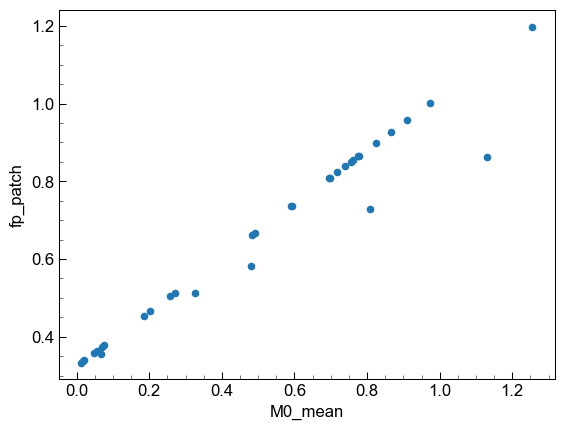

In [76]:
df_dynparam.plot.scatter(x="M0_mean", y="fp_patch" )

In [77]:
#3. compute dc

# compute u_min and dc_min
min_gougeid = 24 # gouge event to use as the minimum event in the set of non-self-similar events 

df_dcmin = df_dynparam[df_dynparam.index == min_gougeid]
dcmin_slip = df_dcmin.slip_try.values[0]
print(f"min utry = {dcmin_slip*1e6:.3g} μm.")
# dc_min = 1e-07 # 9.42e-8 we found the best-fit minimum dc by trial and error inferred from kinematic source energy based values;


min utry = 0.0326 μm.


In [78]:
df_dynparam[df_dynparam.index == min_gougeid]

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try,initialstress_fraction,delsigma_factor,fp_patch,hat_fr,hat_fp_background,hat_fr_background
gougeevent_id,,,,,,,,,,,,,
24,0.065639,0.000002,-6.858558,6000000.0,2000000.0,422824.778368,3.258138e-08,0.98,0.695,0.356099,0.3,0.4,0.4


In [79]:
# Set dc_min from fracture energy scaling
# load the data
sei_types={'Reference M0, a':'category'}
df_seis = pd.read_csv('../../Others/fracture_energy/merged_data-seismology.csv',sep=';',encoding='cp1252',dtype=sei_types)

df_m2014 = df_seis[df_seis["Reference M0, a"] == 'McLaskey et al., 2014']
df_s2019 = df_seis[df_seis["Reference M0, a"] == 'Selvadurai, 2019']
df_y2014 = df_seis[df_seis["Reference M0, a"] == 'Yoshimitsu et al., 2014']
df_s2003 = df_seis[df_seis["Reference M0, a"] == 'Sellers et al., 2003']

### Update: the estimation of $G_{IIC}^{syn}$

$$ G_{IIC}^{syn} (\delta) = 10^{p_0 + p_1 \log_{10}\delta} $$

We decrease the synthetic slope of $G_{IIC}$ as follows:
$$ G_{IIC}^{syn, modified} (\delta) = c 10^{p_0 + p_1 \log_{10} \delta } $$
$$ \log_{10} G_{IIC}^{syn, modified} (\delta) = \log_{10} c + p_0 + p_1 \log_{10}\delta $$

In [80]:
from scipy.optimize import curve_fit

# use the references with the rock sample
slip_all = []
GIIC_all = []
for i, df in enumerate([df_s2003, df_m2014, df_y2014]):
    df = df[df["value (J/m^2)"].astype(float)>0] # select positive GIIC 
    slip_all = np.append(slip_all,  df["value (m)"].astype(float))
    GIIC_all = np.append(GIIC_all,  df["value (J/m^2)"].astype(float))

# regression with the scaling model
# ref: https://stackoverflow.com/a/3433503

popt, pcov = curve_fit(lambda x,a,b: a+b*x ,  np.log10(slip_all),  np.log10(GIIC_all),  p0=(1, 2))

# UPDATE: decrease the interseption of slope to reproduce the smallest event
GIIC_slope_intercept_factor = 0.425 #0.6 # 0.9

popt[0] += np.log10(GIIC_slope_intercept_factor)

slip_syn = np.logspace(-8, -6, 11)

GIIC_syn = 10**(popt[0] + popt[1]*np.log10(slip_syn))


# define the function to estimate GIIC from scaling
def get_GIIC(slp):
    return 10**(popt[0] + popt[1]*np.log10(slp))

In [81]:
popt

array([11.24617142,  1.85637271])

In [82]:
df_dcmin

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try,initialstress_fraction,delsigma_factor,fp_patch,hat_fr,hat_fp_background,hat_fr_background
gougeevent_id,,,,,,,,,,,,,
24,0.065639,0.000002,-6.858558,6000000.0,2000000.0,422824.778368,3.258138e-08,0.98,0.695,0.356099,0.3,0.4,0.4


In [83]:
dc_min = 2*get_GIIC(dcmin_slip) / ((df_dcmin.fp_patch-df_dcmin.hat_fr)*df_dcmin.hat_sn_patch)
print(f"GIIC min: {get_GIIC(dcmin_slip):12.8g}, dc min: {dc_min.values[0]:12.8g}")

GIIC min: 0.0022256265, dc min: 1.3224354e-08


In [84]:
#3. compute dc
df_dynparam["dc_try"] = df_dynparam.apply(lambda x: (dc_min/dcmin_slip**p_dcscaleexp) * (x.slip_try)**p_dcscaleexp, axis=1)
df_dynparam["hat_ds_factor_rapidnuc_nuc"] = hat_ds_factor_rapidnuc_nuc
df_dynparam["hat_ds_factor_rapidnuc_patch"] = hat_ds_factor_rapidnuc_patch

In [85]:
df_dynparam["dc_try"].sort_values() * 1e6

gougeevent_id
128    0.004989
126    0.005884
21     0.006763
9      0.010821
19     0.011991
24     0.013224
44     0.013679
118    0.014449
43     0.024720
40     0.026039
69     0.030046
38     0.030965
50     0.034618
52     0.043696
85     0.043789
89     0.044221
62     0.049386
4      0.049515
109    0.054543
100    0.054561
131    0.055486
61     0.056530
18     0.057297
27     0.057491
77     0.058220
120    0.058276
72     0.059667
99     0.060371
20     0.062148
95     0.064007
31     0.066637
129    0.072981
88     0.077679
Name: dc_try, dtype: float64

Text(0, 0.5, 'Dc [μm]')

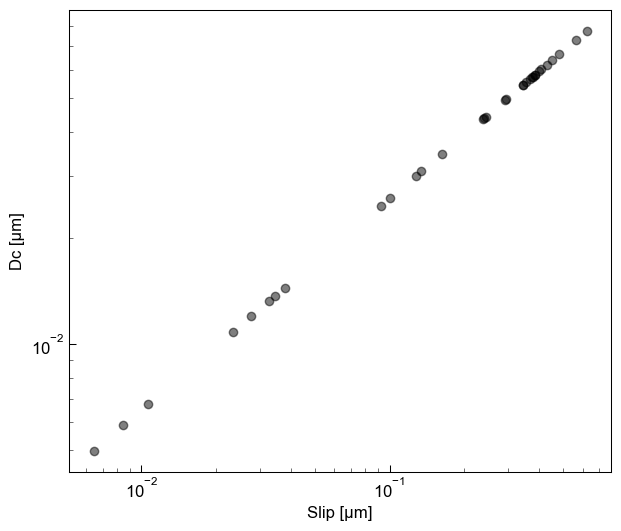

In [86]:
# plot debug Dc distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(df_dynparam["slip_try"]*1e6, df_dynparam["dc_try"].values*1e6, "o", c="k", alpha=0.5)

# ax.text(0.02, 0.5, f"log slope={popt[1]:.3g}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Slip [μm]")
ax.set_ylabel("Dc [μm]")

# ax.set_xlim([1e-3, 1])
# ax.set_ylim([1e-3, 1e-1])

In [87]:
a_test = 2.4e-3
a_test**3/a_patch**3

0.21599999999999994

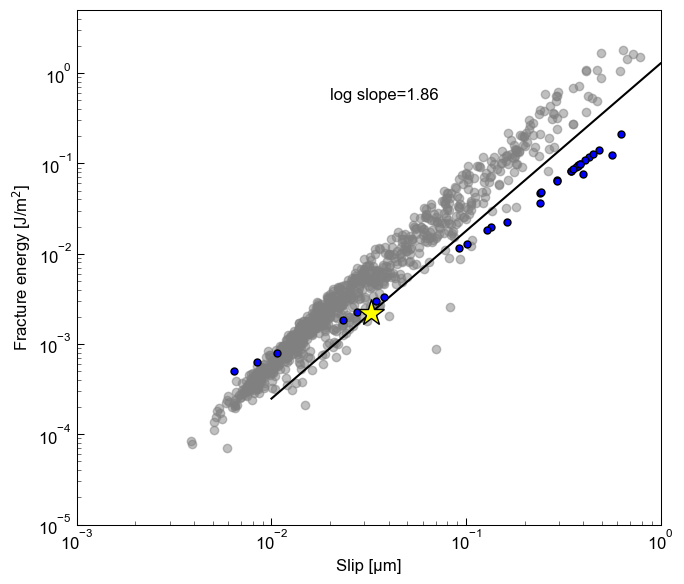

In [88]:
# plot debug for the estimation of minimum Dc and GIIC

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(slip_all*1e6, GIIC_all, "o", c="gray", alpha=0.5)
ax.plot(slip_syn*1e6, GIIC_syn, "k-")

for index, df in df_dynparam.iterrows():
    ax.plot(df.slip_try*1e6, 0.5*df.dc_try*((df.fp_patch-df.hat_fr)*df.hat_sn_patch), "o-", mfc="blue", mec="k", ms=5)
    
ax.plot(dcmin_slip*1e6, 0.5*dc_min*((df_dcmin.fp_patch-df_dcmin.hat_fr)*df_dcmin.hat_sn_patch), "*", mfc="yellow", mec="k", ms=20)

ax.text(0.02, 0.5, f"log slope={popt[1]:.3g}")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Slip [μm]")
ax.set_ylabel("Fracture energy [J/m$^2$]")

ax.set_xlim([1e-3, 1])
ax.set_ylim([1e-5, 0.5e1])

fig.tight_layout()
# fig.savefig("../figure/debug_minDc_fitting.png", dpi=80)

## Commpute the other model parameters

In [89]:
def compute_GIIC(dc, fp, fr, sn):
    return 0.5*dc*(fp-fr)*sn

In [90]:
# Peak and residual frictional resistance for the cohesive law
# the friction coefficient is same between nuc and patch even for the rapid nucleation model
df_dynparam.loc[:, "tau_c_nuc"] = df_dynparam.apply(lambda x: x.fp_patch*(hat_sn_patch*nuc_normalstress_alpha), axis=1) # same fp as the patch
df_dynparam.loc[:, "tau_r_nuc"] = hat_fr_patch * (hat_sn_patch * nuc_normalstress_alpha) # same fr as the patch

df_dynparam.loc[:, "tau_c_patch"] = df_dynparam.apply(lambda x: x.fp_patch*hat_sn_patch, axis=1)
df_dynparam.loc[:, "tau_r_patch"] = hat_fr_patch*hat_sn_patch

df_dynparam.loc[:, "tau_c_background"] = hat_fp_background * hat_sn_background
df_dynparam.loc[:, "tau_r_background"] = hat_fr_background * hat_sn_background
                  
# Initial stress state
# df_dynparam.loc[:, "tau_0_nuc"] = df_dynparam.apply(lambda x: x.tau_c_patch*initialstress_fraction*(1+c_nucexcess), axis=1) # we control the stress in the nucleation area by gaussian distribution with 'c_nucexcess'
df_dynparam.loc[:, "tau_0_nuc"] = df_dynparam.apply(lambda x: x.tau_c_patch*x.initialstress_fraction*(1+c_nucexcess), axis=1) # 
# df_dynparam.loc[:, "tau_0_patch"] = df_dynparam.apply(lambda x: x.tau_c_patch*initialstress_fraction, axis=1)
df_dynparam.loc[:, "tau_0_patch"] = df_dynparam.apply(lambda x: x.tau_c_patch*x.initialstress_fraction, axis=1)
df_dynparam.loc[:, "tau_0_background"] = stressbackground_beta * hat_fr_background * hat_sn_background # for stress-free model, we investigate this value to arrest the rupture by the positive stress drop 

# Compute fracture energy
df_dynparam.loc[:, "GIIC_nuc"] = df_dynparam.apply(lambda x: compute_GIIC(x.dc_try, x.fp_patch, hat_fr_patch, (hat_sn_patch*nuc_normalstress_alpha)), axis=1) # Dc is same as the value in patch 
df_dynparam.loc[:, "GIIC_patch"] = df_dynparam.apply(lambda x: compute_GIIC(x.dc_try, x.fp_patch, hat_fr_patch, hat_sn_patch), axis=1)
df_dynparam.loc[:, "GIIC_background"] = 0.0



## Compute critical nucleation size in nucleation area and patch region
We compute the critical nucleation size of 3D fault with the linear slip weakening law From Galis et al. (2014) as follows:

$$A_{init} = 1.75 S^{2.81} + 3.82 $$

$$ A_{init} = A_i / L_{fric}^2 $$

$$L_{fric} = \mu D_c / (\tau_s - \tau_d) $$

In [91]:
def compute_Sratio(taup, taur, tau0):
    return (taup-tau0)/(tau0-taur)
    
def compute_Ainit(S):
    return 1.75*(S**2.81) + 3.82

def compute_Anuc(Ainit, mu, Dc, tptd):
    return Ainit*((mu*Dc) / (tptd))**2

In [92]:
# compute Sratio
df_dynparam.loc[:, "Sratio_nuc"] = 0 # assume tau0 = taup  as it is in critical state
df_dynparam.loc[:, "Sratio_patch"] = df_dynparam.apply(lambda x: compute_Sratio(x.tau_c_patch, x.tau_r_patch, x.tau_0_patch), axis=1)

# compute Ainit
df_dynparam.loc[:, "Ainit_nuc"] =  df_dynparam.apply(lambda x: compute_Ainit(x.Sratio_nuc), axis=1)
df_dynparam.loc[:, "Ainit_patch"] = df_dynparam.apply(lambda x: compute_Ainit(x.Sratio_patch), axis=1)

# compute Anuc
df_dynparam.loc[:, "Anuc_nuc"] =  df_dynparam.apply(lambda x: compute_Anuc(x.Ainit_nuc, mu, x.dc_try, (x.tau_c_nuc - x.tau_r_nuc)), axis=1)
df_dynparam.loc[:, "Anuc_patch"] = df_dynparam.apply(lambda x: compute_Anuc(x.Ainit_patch, mu, x.dc_try, (x.tau_c_patch - x.tau_r_patch)), axis=1)

# compute rnuc
df_dynparam.loc[:, "rnuc_nuc"] =  df_dynparam.apply(lambda x: np.sqrt(x.Anuc_nuc/np.pi), axis=1) * 1e3
df_dynparam.loc[:, "rnuc_patch"] = df_dynparam.apply(lambda x: np.sqrt(x.Anuc_patch/np.pi), axis=1) * 1e3


(0.0, 4.0)

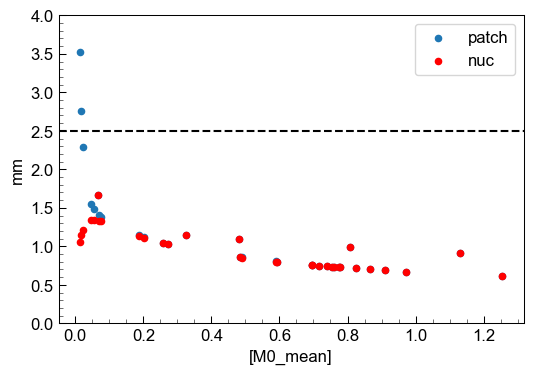

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df_dynparam.plot.scatter(x=["M0_mean"], y=["rnuc_patch"], ylabel="mm", ax=ax, label="patch")
df_dynparam.plot.scatter(x=["M0_mean"], y=["rnuc_nuc"], ylabel="mm", ax=ax, c="r", label="nuc")
ax.axhline(R_nuc*1e3, c="k", ls="--")

ax.set_ylim([0, 4])

In [94]:
gridsize_hpc = 0.041015625 #[mm]
NgridperLc = df_dynparam.loc[129, "rnuc_patch"]/gridsize_hpc
NgridperLc

22.406502073743464

## Check the amplitude of $f_p$

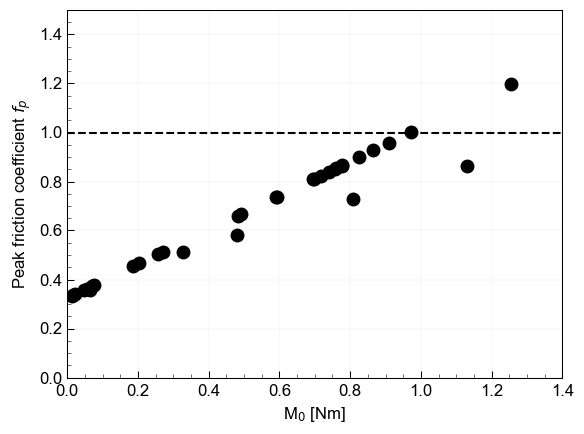

In [95]:
df_dynparam_sorted = df_dynparam.sort_values("fp_patch").copy()

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(df_dynparam_sorted.M0_mean, df_dynparam_sorted.fp_patch, marker="o", c="k", ls="", ms=9, )

# locs, _ = plt.xticks()
# xlabels_all = [int(x.split('__')[1]) for x in df_modelparam.index]
# plt.xticks(locs, xlabels_all)
plt.axhline(1.0, c="k", ls="--")

M0str = r"M$_{\mathrm{0}}$"

ax.set_xlabel('{} [Nm]'.format(M0str))
ax.set_ylabel(r"Peak friction coefficient $f_p$")

ax.tick_params(axis='x', which='major', pad=5)

ax.set_xlim([0, 1.4]);
ax.set_ylim([0, 1.5]);

ax.grid(True, which="major", c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow(True)
fig.tight_layout()

# plt.savefig(figdir + f"/peakfrictioncoef_allevents_{casename}.png", dpi=300, bbox_inches="tight")

# ax.set_title("all the events")

# Computational parameters

In [96]:
# Some other model parameters related to the computation
alpha_domain = 10 # 10 # computational domain size is alpha_domain times larger than radius of gauge
nb_elements = 128 # #256 # number of grids per length; we set same for both x and z directions.

# location of the center of nucleation zone
nuc_z = 0

# duration and time stepping
duration = 6e-6 #10e-6 
tsf = 0.3 # factor of the critical time step

char_reg_time = 0.0 #regularization time of normal stress for the case of linear coulomb friction law

# dumping
dump_fields = "cohesion_0,cohesion_1,cohesion_2,top_disp_0,top_disp_1,top_disp_2,top_velo_0,top_velo_1,top_velo_2,mu_s,mu_k,d_c,load_0,load_1,load_2" # no space
# dump_fields = "cohesion_0,top_disp_0,top_velo_0" # for HPC

# compute the total time step
cs = np.sqrt(mu/rho)
dx = float(R_patch*alpha_domain/nb_elements)
dt_cfl = tsf*dx/cs
Ntimestep = int(duration/dt_cfl)
print(dt_cfl, Ntimestep)

# we control the output frequency by the dt_dump
dt_dump = 2e-8 # [s] output sampling rate: dump data every dt_dump

nb_dumps = int(np.ceil(Ntimestep/(dt_dump/dt_cfl)))
nb_dumps, int(Ntimestep/nb_dumps)

2.6074609372074013e-08 230


(300, 0)

In [97]:
df_dynparam["fp_patch"]

gougeevent_id
4      0.737013
9      0.357049
18     0.850680
19     0.363152
20     0.927031
21     0.339273
24     0.356099
27     0.853655
31     1.001319
38     0.513057
40     0.465720
43     0.453986
44     0.372684
50     0.513730
52     0.581205
61     0.838988
62     0.735219
69     0.503813
72     0.727908
77     0.864889
85     0.660578
88     1.198430
89     0.666128
95     0.957370
99     0.898592
100    0.809466
109    0.809202
118    0.377305
120    0.865756
126    0.336178
128    0.333327
129    0.862647
131    0.823244
Name: fp_patch, dtype: float64

In [98]:
df_dynparam.columns

Index(['M0_mean', 'Tw_mean', 'Mw_mean', 'hat_sn_patch', 'hat_sn_background',
       'delsig_withmargin_try', 'slip_try', 'initialstress_fraction',
       'delsigma_factor', 'fp_patch', 'hat_fr', 'hat_fp_background',
       'hat_fr_background', 'dc_try', 'hat_ds_factor_rapidnuc_nuc',
       'hat_ds_factor_rapidnuc_patch', 'tau_c_nuc', 'tau_r_nuc', 'tau_c_patch',
       'tau_r_patch', 'tau_c_background', 'tau_r_background', 'tau_0_nuc',
       'tau_0_patch', 'tau_0_background', 'GIIC_nuc', 'GIIC_patch',
       'GIIC_background', 'Sratio_nuc', 'Sratio_patch', 'Ainit_nuc',
       'Ainit_patch', 'Anuc_nuc', 'Anuc_patch', 'rnuc_nuc', 'rnuc_patch'],
      dtype='object')

# Dump the file

In [99]:
# inputfileoutdir = f"../../../uguca/simulations_main_casestudy/gouge_rupture_inputfiles_{casestudy_name}"
inputfileoutdir = f"../../../4mNonSelfSim_UGUCA/example_4mNonSelfSim/gouge_rupture_inputfiles_{casestudy_name}"

# remove the previous case study
if os.path.exists(inputfileoutdir):
    shutil.rmtree(inputfileoutdir)

if not os.path.exists(inputfileoutdir):
    os.makedirs(inputfileoutdir)

In [100]:
# make list of parameters
def generate_paramin_rapidnuc(df_model):
    param_in = []
    param_in.append(f"# The gouge patch dynamic rupture input file generated at {datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}\n")
    param_in.append("string simulation_id = fb03-087__{:04d}_{:s}\n".format(df_model.name, casename))
    
    param_in.append("\n# Computational domain size\n")
    param_in.append("double x_length = {:12.8e}\n".format(R_patch*alpha_domain))
    param_in.append("double z_length = {:12.8e}\n".format(R_patch*alpha_domain))
    
    param_in.append("int nb_x_elements = {:d}\n".format(nb_elements))
    param_in.append("int nb_z_elements = {:d}\n".format(nb_elements))
    
    # External loading
    param_in.append("\n# External loading\n")
    param_in.append("double sn_nuc = {:12.8e}\n".format(-hat_sn_patch*nuc_normalstress_alpha)) # sign convention is positive in opening
    param_in.append("double sn_patch = {:12.8e}\n".format(-hat_sn_patch))
    param_in.append("double sn_background = {:12.8e}\n".format(-hat_sn_background))
    
#     param_in.append("double tau_nuc = {:12.8e}\n".format(df_model.tau_0_nuc))
    param_in.append("double tau_patch = {:12.8e}\n".format(df_model.tau_0_patch))
    param_in.append("double tau_background = {:12.8e}\n".format(df_model.tau_0_background))
    
    param_in.append("\n# Material constants\n")
    param_in.append("double E_top = {:12.8e}\n".format(E))
    param_in.append("double nu_top = {:12.8e}\n".format(nu))
    param_in.append("double rho_top = {:12.8e}\n".format(rho))
    
    # Frictional parameters; uniform GIIC in the patch
    param_in.append("\n# Frictional parameters\n")
    param_in.append("double Gc_nuc = {:12.8e}\n".format(df_model.GIIC_nuc))
    param_in.append("double tau_c_nuc = {:12.8e}\n".format(df_model.tau_c_nuc))
    param_in.append("double tau_r_nuc = {:12.8e}\n".format(df_model.tau_r_nuc))
    
    param_in.append("double Gc_patch = {:12.8e}\n".format(df_model.GIIC_patch))
    param_in.append("double tau_c_patch = {:12.8e}\n".format(df_model.tau_c_patch))
    param_in.append("double tau_r_patch = {:12.8e}\n".format(df_model.tau_r_patch))
    
#     param_in.append("double Gc_background = {:12.8e}\n".format(df_model.GIIC_patch)) # To avoid the zero division, we set the same GIIC as the patch; not used in the simulation with Coulomb's law
    param_in.append("double tau_c_background = {:12.8e}\n".format(df_model.tau_c_background))
    param_in.append("double tau_r_background = {:12.8e}\n".format(df_model.tau_r_background))
    
    param_in.append("double dc_nuc = {:12.8e}\n".format(df_model.dc_try)) # same as the patch
    param_in.append("double ds_nuc = {:12.8e}\n".format(hat_ds_factor_rapidnuc_nuc * df_model.dc_try))
#     param_in.append("double ds_nuc = {:12.8e}\n".format(hat_ds_nuc))
    param_in.append("double fp_nuc = {:12.8e}\n".format(df_model.fp_patch)) # same as the fp patch, which is modified when using fp Gaussian nucleation
#     param_in.append("double fr_nuc = {:12.8e}\n".format(df_model.hat_fr/nuc_normalstress_alpha)) # after the nucleation, stress drop is same level with the patch domain #(df_model.hat_fr))
    param_in.append("double fr_nuc = {:12.8e}\n".format(df_model.hat_fr)) # set same fr as the patch
  
    param_in.append("double dc_patch = {:12.8e}\n".format(df_model.dc_try))
    param_in.append("double ds_patch = {:12.8e}\n".format(hat_ds_factor_rapidnuc_patch * df_model.dc_try))
#     param_in.append("double ds_patch = {:12.8e}\n".format(hat_ds_patch))
    param_in.append("double fp_patch = {:12.8e}\n".format(df_model.fp_patch))
    param_in.append("double fr_patch = {:12.8e}\n".format(df_model.hat_fr))
    
    param_in.append("double dc_background = {:12.8e}\n".format(df_model.dc_try)) # need to be non-zero to avoid zero devision
    param_in.append("double ds_background = {:12.8e}\n".format(hat_ds_factor_rapidnuc_background * df_model.dc_try))
    # param_in.append("double dc_background = {:12.8e}\n".format(100*df_model.dc_try)) # need to be non-zero to avoid zero devision
    # param_in.append("double ds_background = {:12.8e}\n".format(100*hat_ds_factor_rapidnuc_background * df_model.dc_try))
    param_in.append("double fp_background = {:12.8e}\n".format(df_model.hat_fp_background)) #### peak is same as redisual in background
    param_in.append("double fr_background = {:12.8e}\n".format(df_model.hat_fr_background))
    

    # patch sizes
    param_in.append("\n# Patch sizes and locations\n")
    param_in.append("double R_nuc = {:12.8e}\n".format(R_nuc)) # sign convention is positive in opening
    param_in.append("double R_patch = {:12.8e}\n".format(R_patch))
    param_in.append("double R_margin = {:12.8e}\n".format(R_margin))
    
    param_in.append("double nuc_x = {:12.8e}\n".format(nuc_x))
    param_in.append("double nuc_z = {:12.8e}\n".format(nuc_z))

    param_in.append("double c_nucexcess = {:12.8e}\n".format(c_nucexcess))
#     param_in.append("double alpha_fpnuc = {:12.8e}\n".format(alpha_fpnuc)) 
#     param_in.append("double c_fpnuc = {:12.8e}\n".format(c_fpnuc))

    # simulation parameters
    param_in.append("\n# Simulation parameters\n")
    param_in.append("double duration = {:12.8e}\n".format(duration))
    param_in.append("double tsf = {:12.8e}\n".format(tsf))
    param_in.append("double char_reg_time= {:12.8e}\n".format(char_reg_time))
    
    param_in.append("string dump_fields = {:s}\n".format(dump_fields))
    param_in.append("int nb_dumps = {:d}\n".format(nb_dumps))

    return param_in

## Write the input files

In [101]:
# select some cases for preliminary result
selectids = [129] # New set of non-self-similar events with merged event catalog.
# selectids = [50, 52, 72, 129] # New set of non-self-similar events with merged event catalog.
# selectids = [24] # New set of non-self-similar events with merged event catalog.



In [102]:
for i, df_model in df_dynparam.iterrows():
    if i not in selectids:
        # print(i)
        continue
        
    foname = inputfileoutdir+f"/rupgougepatch_fb03-{expr_id:03d}__{df_model.name:04d}_{casename}.in"
    print(f"output {foname}")
#     param_in = generate_paramin(df_model)
#     param_in = generate_paramin_linear_coulomb_friction_law(df_model)
    param_in = generate_paramin_rapidnuc(df_model)
    # output file
    with open(foname, "w") as fo:
        fo.writelines(param_in)

output ../../../4mNonSelfSim_UGUCA/example_4mNonSelfSim/gouge_rupture_inputfiles_a=4.00_ruptype=pulse_pdcscaling=0.600/rupgougepatch_fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35.in


In [103]:
# Dump the csv file
# df_dynparam.to_csv(f"../../../4mNonSelfSim_UGUCA/example_4mNonSelfSim/gouge_dynamicrupture_modelparam_{casename}.csv", float_format="%12.8e")